In [ ]:
# which versions?
%%bash

cat > requirements.txt << EOF
numpy
matplotlib
scipy
pymc3
arviz
pandas
EOF

pip install -r requirements.txt

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano
import theano.ifelse
from theano import tensor

import pymc3 as pm
from pymc3 import  *

In [8]:
az.style.use('arviz-darkgrid')

In [9]:
# Value (in chilean pesos) of the permit that traders pay to fishers per legal unit
visa = 3000.    
C_i = 5000.       # Illegal price of reference at the port per unit: This comes from my fieldwork 1
C_l = C_i + visa  # Elasticity of demand at the port for legal, based on previous and current catch
# C_i = C_i       # Elasticity of demand at the port for illegal, based on previous and current catch

f = 9.2e+05  # Fine expected per box, from chilean law

# Days of operation
daysop = 200.

# beta is price_premium, i.e. how much more expensive legal than illegal price is, 
# P_l = P_i + beta
P_i = 17000.  # Illegal price of reference at market per unit: This comes from my fieldwork 2
beta_min = 0.
beta_max = 6000.  # unrealistically high higher limit

# Probability of detection per box
# The number 5e-05 comes from the enforcement records data, 
theta_min = 0.
theta_max = 3 * 5e-05

# Prior for landings (total units landed each year, considering legal and illegal)
quota = 3200000. / 27.  # 3200 ton quota in 2018. Divided in 27 because "units" are 27 kg boxes
# TODO shouldn't nmin be 3*quota?
T_min = quota / daysop  # Landings lower limit: 3X the legal quota is from one of our papers
T_max = (27000000. / 27.) / daysop  # Landings higher limit: 27,4K ton is from our paper as well

sigma = quota * (10. / 100.) / 3.  # solves 3 * sigma = 10% quota since with P(|x-mu|<3*sigma)=99.73

In [16]:
"""Emile:
1/ What do we observe? legal units? or total units (legal + illegal) ?
- a/ Shouldn't we put a prior on x_i, solve for the optimal x_l 
and observe x_l or x_l + x_i?
- since x_l -> Profit(x_l) is linear, depending on the sign of the slope, the optimum
would either be x_l^* = 0 or x_l^* = capacity - x_i
- b/ If we observe x_l + x_, similarly we could put a prior on x_l, and solve for x_i
Since x_i -> Profit(x_i) is quadratic with negative coefficient its stationary point is a local maximum
the optimal would then be x_i^* = max(0, min(argmax Profit(x_i), capacity - x_l))
2/ How so we know P_i but not P_l? (although in pratice that doesn't really change anything)
3/ Similarly how come we know C_i but not C_l?
"""

class MyModel(pm.Model):
    def __init__(self, name='', model=None):
        super().__init__(name, model)
        
        # Define priors
        beta = Uniform('beta', beta_min, beta_max)
        theta = Uniform('theta', theta_min, theta_max)  # Emile: have a mean from enforcement data, should use that (e.g. Gamma prior)
        T = Uniform('T', T_min, T_max)

        # Model for one time period
        P_l = P_i + beta
        # Function 6 in draft, calculates the optimal quantity of illegal units. Divided by 100 to convert to ratio
        # x_i = ((((P_i - wi - pl + wl - (fb * D)) / (8 * D * pl)))) / 100.  # Illegal units
        x_i_possibly_out_of_bounds = (P_i - C_i - (f * theta) - P_l + C_l) / (2 * theta * P_l)
        x_i_not_negative = theano.ifelse.ifelse(tensor.lt(x_i_possibly_out_of_bounds, 0.), 
                                                0. * x_i_possibly_out_of_bounds, 
                                                x_i_possibly_out_of_bounds)
        x_i = theano.ifelse.ifelse(tensor.gt(x_i_not_negative, T), 
                                   T, 
                                   x_i_not_negative)
        x_l = T - x_i
        # Calculates the total (for a year)
        T_per_year = T * daysop
        x_l_per_year = x_l * daysop

        # if we want to be able to plot posterior distributions over these intermediate variables we have to do this
        P_l = pm.Deterministic('P_l', P_l)
        x_i = pm.Deterministic('x_i', x_i)
        x_l = pm.Deterministic('x_l', x_l)
        T_per_year = pm.Deterministic('T_per_year', T_per_year)
        x_l_per_year = pm.Deterministic('x_l_per_year', x_l_per_year)

        # Define likelihood
        likelihood = Normal('quota', mu=T_per_year, sigma=sigma, observed=quota)  # Emile: are we not observing "landings", i.e x_l * dayopt ?

mymodel = MyModel()

In [11]:
with Model() as model:
    MyModel()
    
    # Inference
    # Draw 11000 posterior samples using NUTS
    trace = sample(draws=11000, chains=2, cores=1)# tune=1000, chains=4, cores=4, target_accept=0.95) # not running in parallel?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [T, theta, beta]
100%|██████████| 11500/11500 [00:11<00:00, 982.75it/s] 
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


# Prior predictive check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08467c18d0>,
      dtype=object)

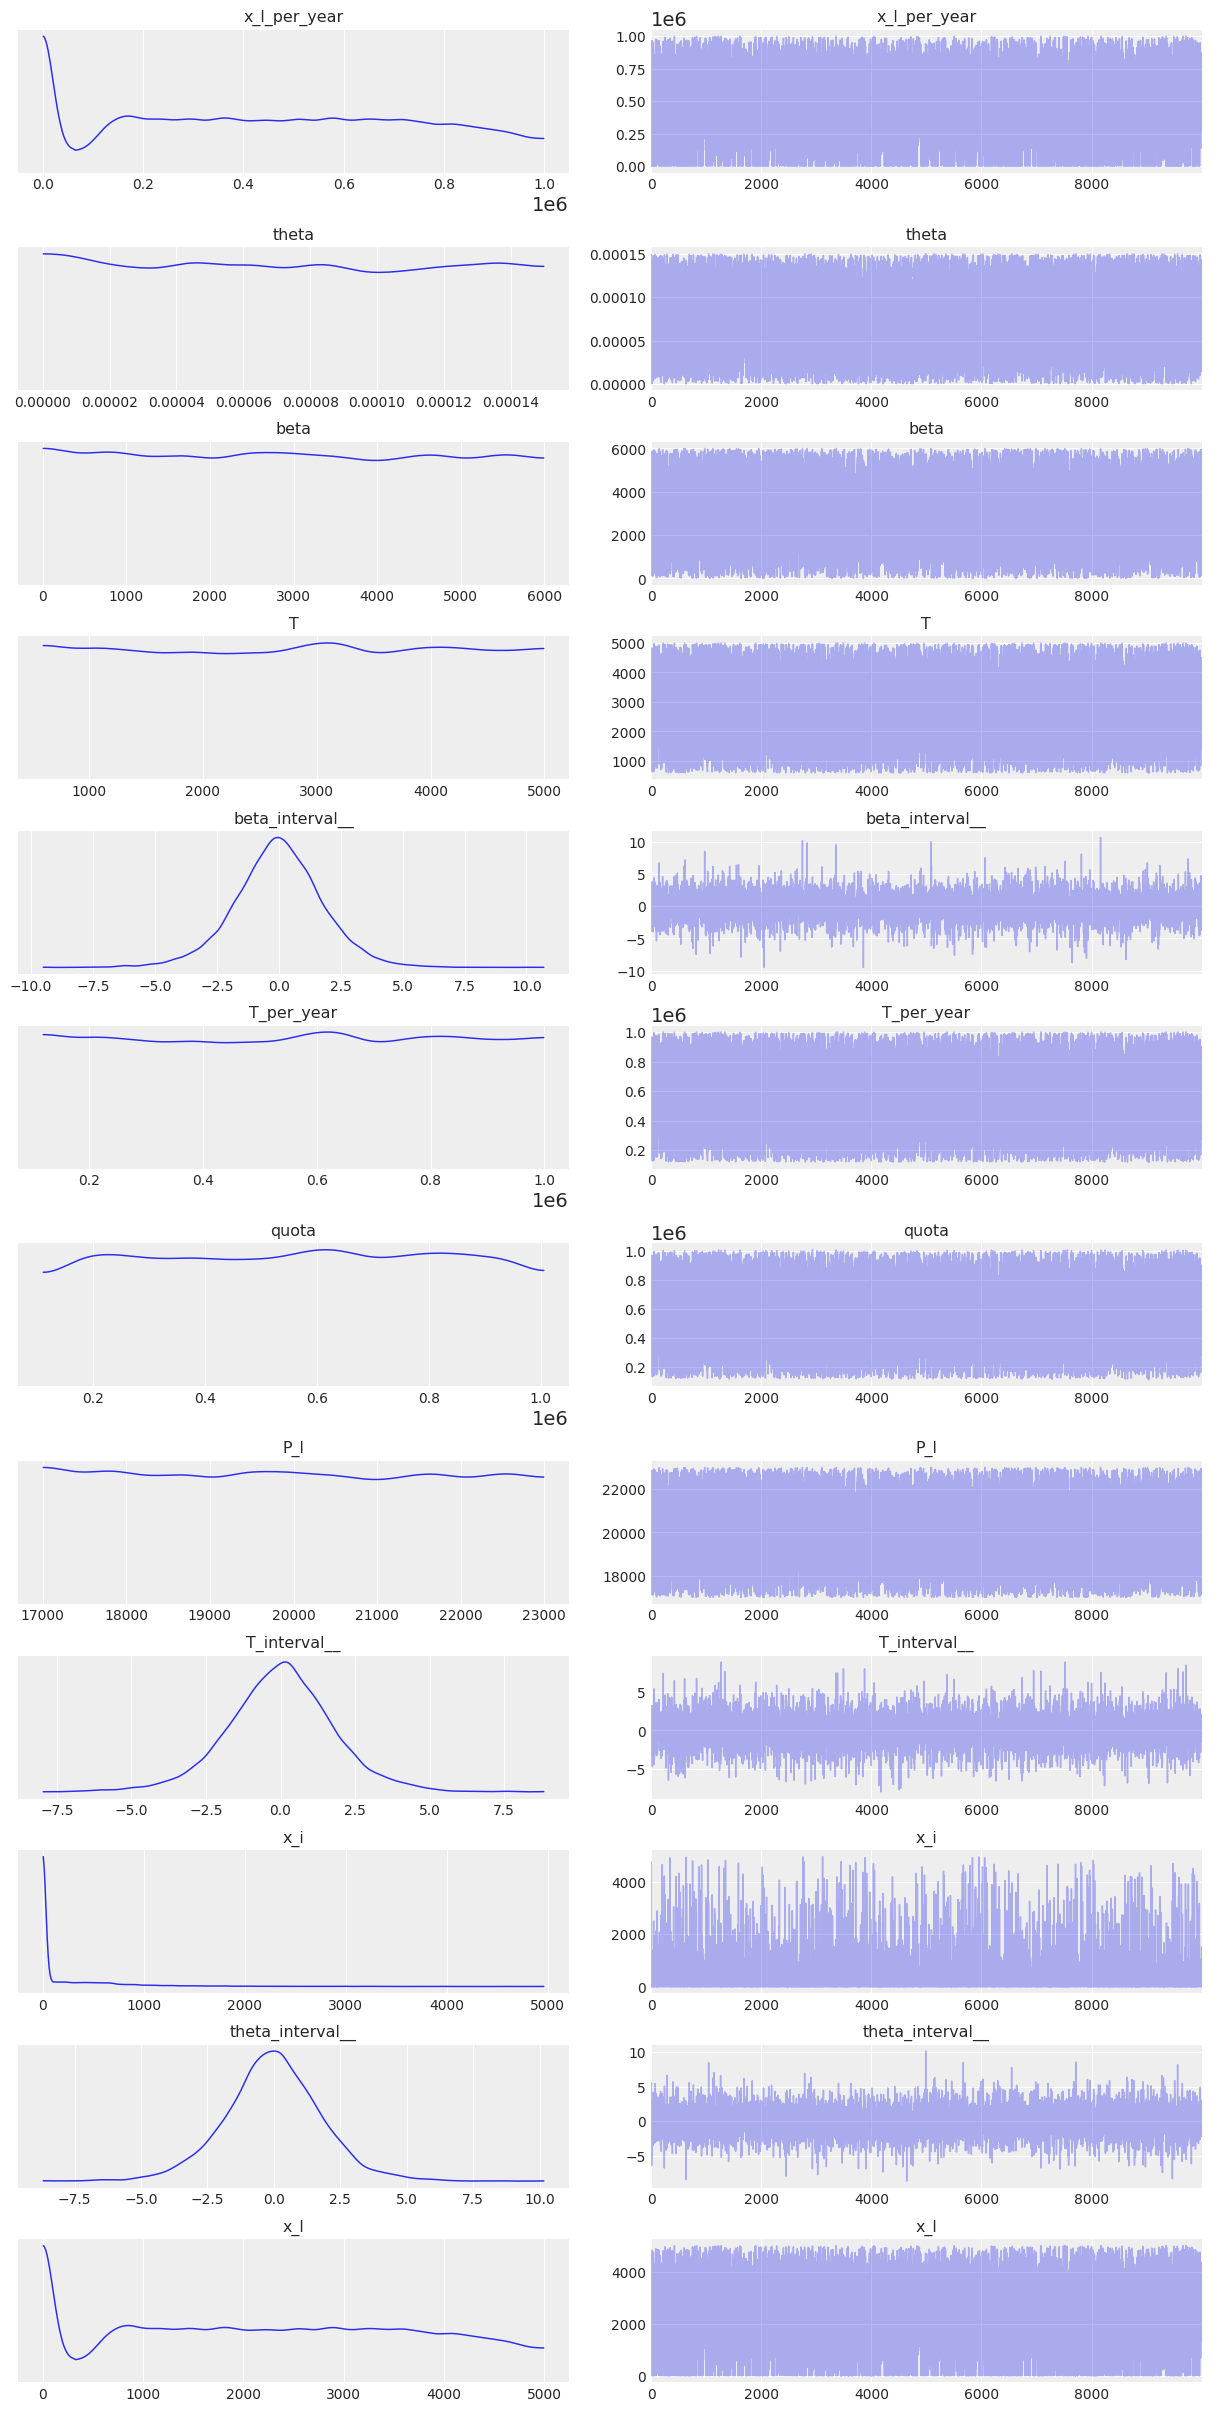

In [12]:
prior_checks = sample_prior_predictive(samples=10000, random_seed=0, model=mymodel)
traceplot(prior_checks)
# traceplot({k: prior_checks[k] for k in ('x_i', 'x_l')})

# Posterior inference

In [13]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


AttributeError: ignored

<Figure size 700x700 with 0 Axes>

# Some debugging

In [14]:
beta = 1000
theta = 5e-05
T = T_min

# Model for one time period
P_l = P_i + beta
# Function 6 in draft, calculates the optimal quantity of illegal units. Divided by 100 to convert to ratio
# x_i = ((((P_i - wi - pl + wl - (fb * D)) / (8 * D * pl)))) / 100.  # Illegal units
x_i = (P_i - C_i - f * theta - P_l + C_l) / (-2. * theta * P_l)

if x_i < 0:
    x_i = 0.
elif x_i > 0:
    x_i = T
x_l = T - x_i

# Calculates the total (for a year)
T_per_year = T * daysop

P_l, x_i, x_l, T_per_year

(18000.0, 0.0, 592.5925925925926, 118518.51851851853)

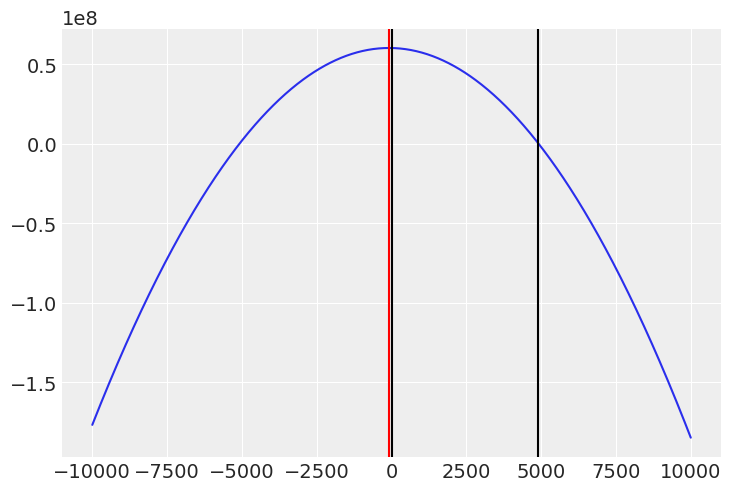

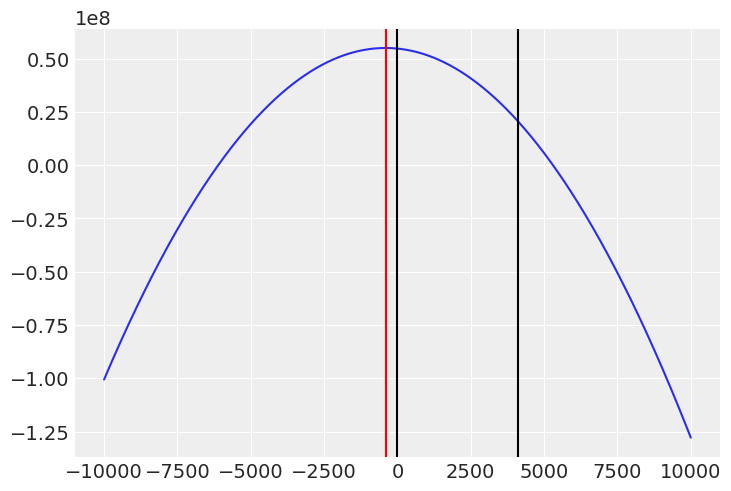

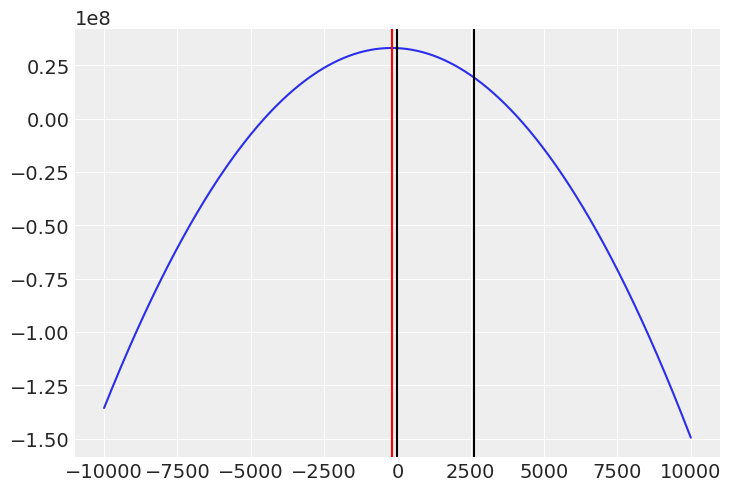

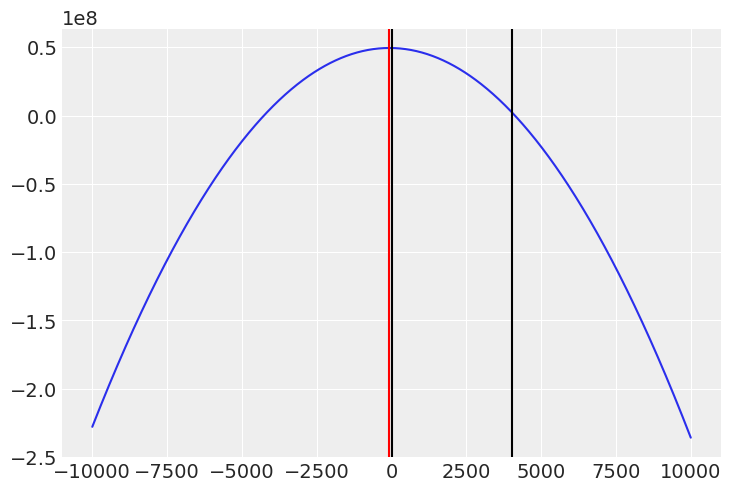

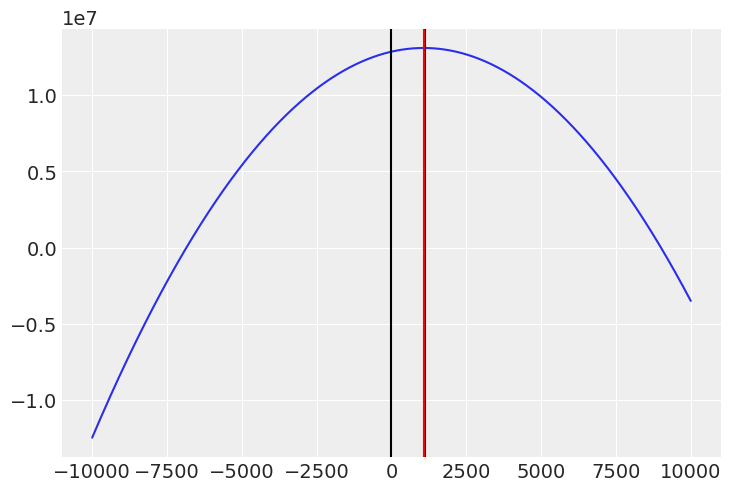

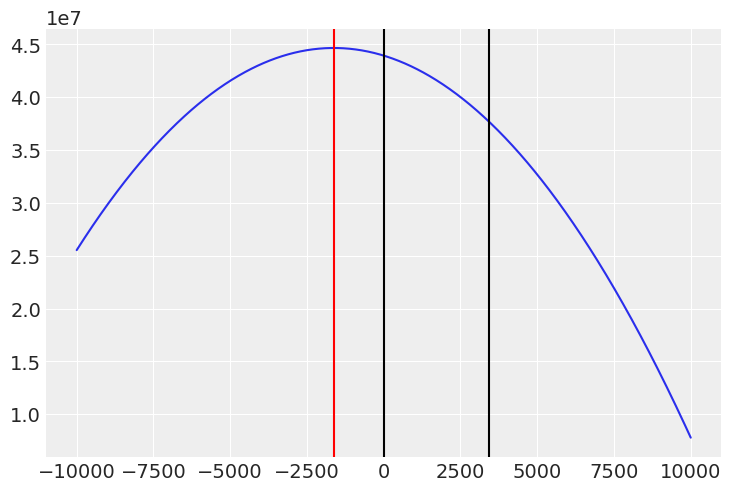

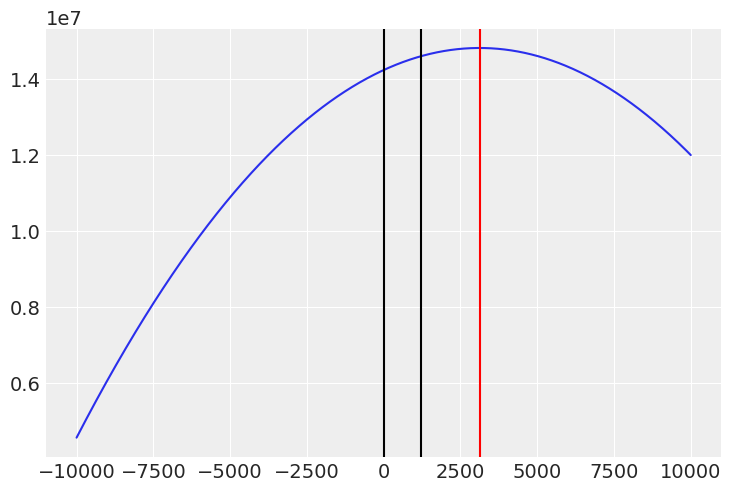

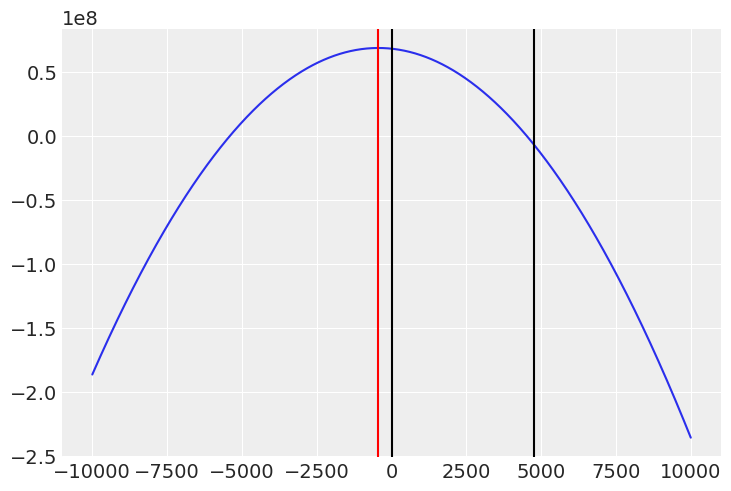

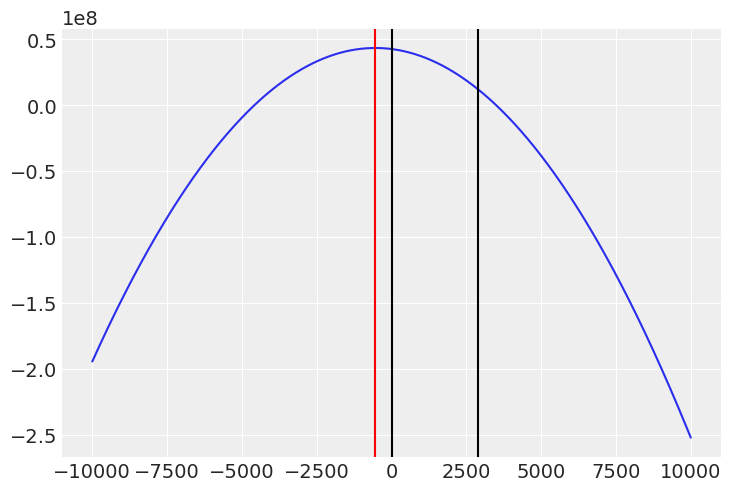

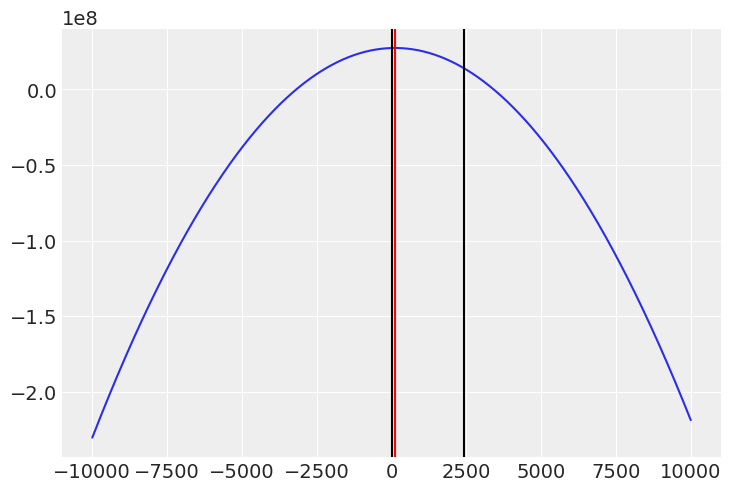

In [15]:
N = 10
samples = sample_prior_predictive(samples=N, random_seed=0, model=mymodel)

for i in range(N):
    theta,P_l,T = tuple(samples[k][i] for k in ('theta,P_l,T'.split(',')))
    
    x_range = 10000
    x_i = np.linspace(-x_range, x_range, 1000)
    x_l = T - x_i
    y = (P_i - C_i)*x_i - (theta * x_i * (P_l * x_i + f)) + (P_l - C_l)*x_l
    
    x_i_opt = (P_i - C_i - f * theta - P_l + C_l) / (2. * theta * P_l)

    plt.plot(x_i, y)
    plt.axvline(0., color='k')
    plt.axvline(T, color='k')
    plt.axvline(x_i_opt, color='r')
    plt.show()